# Full script for LSTM cryptocurrency prediction

u743346
<br>
Gerlof Bremmer
<br>
g.d.bremmer@tilburguniversity.edu

Import neccasary packages and set random seed for reproducability

In [2]:
from math import sqrt
import math

import numpy as np
from numpy import concatenate

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import time

from matplotlib import pyplot
import matplotlib.pyplot as plt


import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas import Panel

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

import tensorflow as tf

Using TensorFlow backend.


In [3]:
seed = 1337
np.random.seed(seed)

pylab inline to show graphs inline

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/gerlofbremmer/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. Comment data pre-processing and sentiment calculation

Load scraped data json

In [ ]:
ltc = pd.read_json('ltc.json', lines=True)
xrp = pd.read_json('xrp.json', lines=True)
eth = pd.read_json('eth.json', lines=True)

Exploration

In [ ]:
ltc.info()
eth.info()
xrp.info()

Test if all comment ID's are unique

In [ ]:
def unique(df):
    return df.id.nunique()

print(unique(ltc))
print(unique(eth))
print(unique(xrp))

Filtering the dataset to only usefull columns

In [ ]:
def filter_col(df, cols):
    return df.drop(df.columns[[cols]], axis=1)

ltc = filter_col(ltc, [0,2,3,4,5,6,7,8,9,11,12,13,14,15,16,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,35,36,37,38,39])
eth = filter_col(eth, [0,2,3,4,5,6,7,8,9,11,12,13,14,15,16,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,35,36,37,38,39])
xrp = filter_col(xrp, [0,2,3,4,5,6,7,8,9,11,12,13,14,15,16,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,35,36,37,38,39])


Drop comments from before 01-01-2016 = after epoch 1451606401 & before 1514764799

In [ ]:
ltc = ltc[ltc['created_utc'] >= 1451606401]
ltc = ltc[ltc['created_utc'] <= 1514764799]
eth = eth[eth['created_utc'] >= 1451606401]
eth = eth[eth['created_utc'] <= 1514764799]
xrp = xrp[xrp['created_utc'] >= 1451606401]
xrp = xrp[xrp['created_utc'] <= 1514764799]

Change created_utc to readble datetime

In [ ]:
def to_datetime(df):
    return pd.to_datetime(df['created_utc'],unit='s')

ltc['datetime'] = to_datetime(ltc)
eth['datetime'] = to_datetime(eth)
xrp['datetime'] = to_datetime(xrp)

Remove 'removed' and 'deleted' comments

In [ ]:
ltc = ltc[ltc.body != '[removed]']
ltc = ltc[ltc.body != '[deleted]']
xrp = xrp[xrp.body != '[removed]']
xrp = xrp[xrp.body != '[deleted]']
eth = eth[eth.body != '[removed]']
eth = eth[eth.body != '[deleted]']

Perform VADER sentiment analysis on every sentence; new columns: compound, negative, neutral, positive
<br>
NOTE: computational extensive process

In [ ]:

analyzer = SentimentIntensityAnalyzer()
ltc[['compound','neg','neu','pos']] = ltc['body'].apply(lambda body: pd.Series(analyzer.polarity_scores(body)))
xrp[['compound','neg','neu','pos']] = xrp['body'].apply(lambda body: pd.Series(analyzer.polarity_scores(body)))
eth[['compound','neg','neu','pos']] = eth['body'].apply(lambda body: pd.Series(analyzer.polarity_scores(body)))
                                                               

grouping the data on datetime (day) simoultaniously calculating mean of sentiment scores + drop nan values

resulting in 730 entries for LTC and ETH and 538 days for XRP

In [ ]:

def mean_grouping(df):
    return df.set_index('datetime').groupby(pd.TimeGrouper('D')).mean().dropna()

ltccomment = mean_grouping(ltc)
xrpcomment = mean_grouping(xrp)
ethcomment = mean_grouping(eth)


Counting number of comments per day and adding column numcomments

In [ ]:

def comment_count(df):
    return df.set_index('datetime').resample('D').size()
    
ltccomment['numcomments'] = comment_count(ltc)
xrpcomment['numcomments'] = comment_count(xrp)
ethcomment['numcomments'] = comment_count(eth)


Mean, max, min for sentiment compound and karma score of comments

In [ ]:

def min_max_mean(coin, df):
    print("Minumum compound ", coin," :" ,df['compound'].min())
    print("Maximum compound ", coin," :" ,df['compound'].max())
    print("Mean of compound ", coin," :" ,df['compound'].mean())
    print("\n")
    
min_max_mean('LTC', ltc)
min_max_mean('ETH', eth)
min_max_mean('XRP', xrp)

In [ ]:
def min_max_score(coin, df):
    print("Minumum score",coin," : " ,df['score'].min())
    print("Maximum score",coin," : " ,df['score'].max())
    print("\n")
    
min_max_score('LTC', ltc)
min_max_score('ETH', eth)
min_max_score('XRP', xrp)

Saving DF with sentiment as pickle for later analysis

In [ ]:
ltccomment.to_pickle('Litecoin2016-17.pkl')
ethcomment.to_pickle('Ethereum2016-17.pkl')
xrpcomment.to_pickle('Ripple2016-17.pkl')

# 2. Price data pre-processing

Read in prices.csv

In [ ]:
prices = pd.read_csv("prices.csv" , parse_dates= ['date'])

Exploration

In [ ]:
prices.info()
prices[0:100]
prices.loc[prices['symbol'] == 'XRP']

Creating 3 datasets with date as index (corrosponding to sentiment data)

In [ ]:
def date_index(df, coin):
    return df[df['symbol'] == coin].set_index('date')

pricesLTC = date_index(prices, 'LTC')
pricesETH = date_index(prices, 'ETH')
pricesXRP = date_index(prices, 'XRP')

Filter date only 01-01-2016 to 31-12-2017

In [ ]:
def filter_date(df, after, before):
    return df.ix[after:before]

pricesLTC = filter_date(pricesLTC, '2016-01-01','2017-12-31')
pricesETH = filter_date(pricesETH, '2016-01-01','2017-12-31')
pricesXRP = filter_date(pricesXRP, '2016-01-01','2017-12-31')

Calculate extra variables and add as new columns

In [ ]:
def operations(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['prices'] = df[['open', 'close','high','low']].mean(axis=1)
    df['delta_day'] = df['high'] - df['low']
    df['fluctuation'] = 0
    df['fluctuation'] = df.delta_day.diff().fillna(0)
    df['norm_fluctuation'] = 0
    df['norm_fluctuation'] = scaler.fit_transform(df[['fluctuation']])
    df['pct_change']= df['prices'].pct_change()
    df['log_pct_change'] = np.log(df['prices'].astype('float64')/df['prices'].astype('float64').shift(1))
    #df['norm_compound'] = 0
    #df['norm_compound'] = scaler.fit_transform(df[['compound']])
    
operations(pricesLTC)
operations(pricesETH)
operations(pricesXRP)

Save price data to pickle for merging with sentiment data

In [ ]:
pricesLTC.to_pickle('pricesLTC2016-17.pkl')
pricesXRP.to_pickle('pricesXRP2016-17.pkl')
pricesETH.to_pickle('pricesETH2016-17.pkl')

# 3. Merging, corrolation and visualization

Import comment data and price data

In [ ]:
ltc = pd.read_pickle('Litecoin2016-17.pkl')
eth = pd.read_pickle('Ethereum2016-17.pkl')
xrp = pd.read_pickle('Ripple2016-17.pkl')


priceltc = pd.read_pickle('pricesLTC2016-17.pkl')
pricexrp = pd.read_pickle('pricesXRP2016-17.pkl')
priceeth = pd.read_pickle('pricesETH2016-17.pkl')

Merge datasets on index

In [ ]:
def merge(leftdf, rightdf):
    return pd.merge(leftdf,rightdf, how='inner', left_index=True, right_index=True)
    

mergeltc = merge(priceltc, ltc)
mergeeth = merge(priceeth, eth)
mergexrp = merge(pricexrp, xrp)

Output the corrolation matrix between variables

In [ ]:
def corr_matrix(df):
    df = df[['prices','volume','delta_day', 'compound', 'numcomments']]
    return df.corr(method='pearson')
    
corr_matrix(eth)

Display top corrolations

In [ ]:
def correlation_top(df):
    corre = df.corr(method='pearson')
    c1 = corre.abs().unstack()
    results = c1.sort_values(ascending = False)
    print(results[0:150])
    
correlation_top(xrp)

Set size of plot to fixed size 15x9

In [25]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# 4. LSTM prediction

Load the datasets for analysis

In [16]:
ltc = pd.read_pickle('mergeLTC2016-17.pkl')
eth = pd.read_pickle('mergeETH2016-17.pkl')
xrp = pd.read_pickle('mergeXRP2016-17.pkl')

Steps for choosing the analysis:
<br>
- Copy data of cryptocurrency to temporary df
- Specify the input variables as string in function call
<br>
eg: prices = 1 lag day prices, compound = 1 lag day compound
<br>
All variables:
df = choose_crypto(ltc ,'prices','compound', 'numcomments')

In [17]:

def choose_crypto(crypto, *vars):
    df = crypto
    if len(vars) == 4:
        df = df[[vars[0],vars[1],vars[2],vars[3]]]
    elif len(vars) == 3:
        df = df[[vars[0],vars[1],vars[2]]]
    elif len(vars) == 2:
        df = df[[vars[0],vars[1]]]
    else:
        df = df[[vars[0]]]
    return df

df = choose_crypto(eth, 'prices' )

- Load dataset as values
- Ensure all data is float
- Normalize features using MinMaxScaler

In [18]:
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

- Specify the number of lag days and features above function
<br>
INCORRECT n_features AND n_days WILL RESULT IN ERROR

In [19]:

n_days = 1
n_features = 1

# convert series to supervised learning by shifting t-1, t-2, t-3 depending on lag of days
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    #input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# frame as supervised learning
reframed = series_to_supervised(scaled, n_days,1)

print(reframed.shape)
print(reframed.head(), '\n')

if df.shape[1] != n_features:
    print('ERROR: n_features must match input variables')

(730, 2)
   var1(t-1)   var1(t)
1   0.000000  0.000007
2   0.000007  0.000021
3   0.000021  0.000020
4   0.000020  0.000016
5   0.000016  0.000009 



- Split into train and test sets
<br>
- Reshape input to be 3D [samples, timesteps, features]

In [20]:
values = reframed.values
n_train_days = 0.8*len(reframed)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

#split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

if df.shape[1] != n_features:
    print('ERROR: n_features must match input variables')

(584, 1) 584 (584,)
(584, 1, 1) (584,) (146, 1, 1) (146,)


/Users/gerlofbremmer/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/gerlofbremmer/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Compile the LSTM model

In [21]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


Fit the model and plot the losses

Train on 584 samples, validate on 146 samples
Epoch 1/130
584/584 [==============================] - 1s 872us/step - loss: 0.0436 - val_loss: 0.3883
Epoch 2/130
584/584 [==============================] - 0s 173us/step - loss: 0.0460 - val_loss: 0.3830
Epoch 3/130
584/584 [==============================] - 0s 163us/step - loss: 0.0453 - val_loss: 0.3833
Epoch 4/130
584/584 [==============================] - 0s 161us/step - loss: 0.0426 - val_loss: 0.3831
Epoch 5/130
584/584 [==============================] - 0s 166us/step - loss: 0.0411 - val_loss: 0.3746
Epoch 6/130
584/584 [==============================] - 0s 179us/step - loss: 0.0412 - val_loss: 0.3696
Epoch 7/130
584/584 [==============================] - 0s 162us/step - loss: 0.0405 - val_loss: 0.3666
Epoch 8/130
584/584 [==============================] - 0s 161us/step - loss: 0.0393 - val_loss: 0.3597
Epoch 9/130
584/584 [==============================] - 0s 160us/step - loss: 0.0393 - val_loss: 0.3551
Epoch 10/130
584/584 [=====

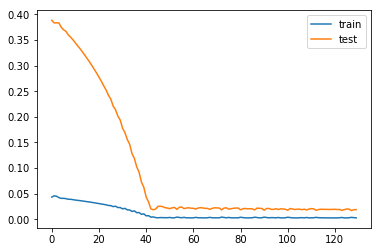

In [22]:
history = model.fit(train_X, train_y, epochs=130, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Prediction of the model.
<br>
Following steps are taken:
<br>
- Prediction
- Invert scaling for forecast
- Invert scaling for actual
- Calculate RMSE
- Prediction on train
- Invert scaling for train forecast
- Invert scaling for train actual
- Calculate train RMSE
- Calculate MAPE

In [23]:
# make a prediction with model
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE


# make a prediction with model for train
trainyhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], n_days*n_features))
# invert scaling for forecast
traininv_yhat = concatenate((trainyhat, train_X[:, -(n_features-1):]), axis=1)
traininv_yhat = scaler.inverse_transform(traininv_yhat)
traininv_yhat = traininv_yhat[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
traininv_y = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)
traininv_y = scaler.inverse_transform(traininv_y)
traininv_y = traininv_y[:,0]



trainrmse = sqrt(mean_squared_error(traininv_y, traininv_yhat))
testrmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Train RMSE (Root Mean Squared Error): %.3f' % trainrmse)
print('Test RMSE (Root Mean Squared Error): %.3f' % testrmse)
print('')

testmae = mean_absolute_error(inv_y, inv_yhat)
trainmae = mean_absolute_error(traininv_y, traininv_yhat)

print('Train MAE (Mean Absolute Error): %.3f' % trainmae)
print('Test MAE (Mean Absolute Error): %.3f' % testmae)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(inv_y, inv_yhat )
print("Mean Absolute Percentage Error = ", MAPE)

Train RMSE (Root Mean Squared Error): 6.625
Test RMSE (Root Mean Squared Error): 26.092

Train MAE (Mean Absolute Error): 2.987
Test MAE (Mean Absolute Error): 15.892
Mean Absolute Percentage Error =  3.73476222157


Plot predicted versus real values

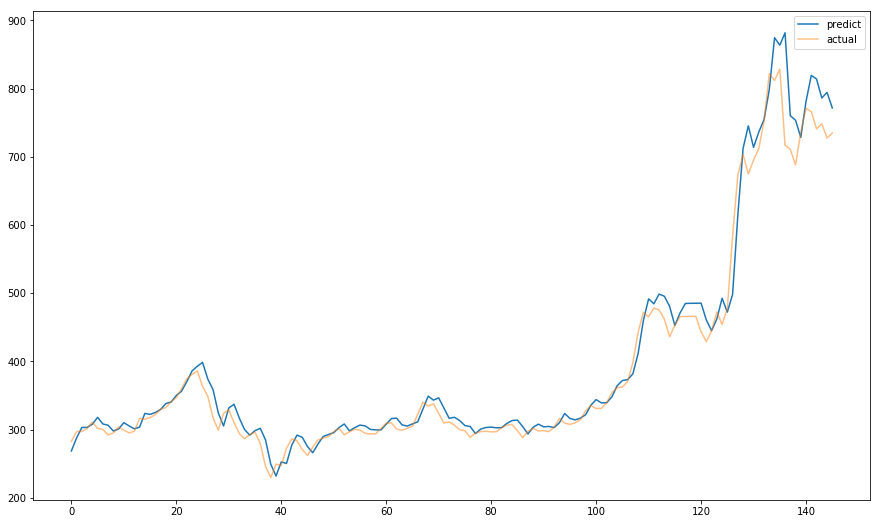

In [26]:
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

Create dataframe whith predicted, true and percentge difference between predicted and true

In [27]:
d = {'real':inv_y, 'pred':inv_yhat}
pred = DataFrame(data=d)
pred['percentage change'] = (((pred['pred'] - pred['real'])/(pred['real']))*100)
pred['pred_change'] = pred.pred.diff().fillna(0)
pred['real_change'] = pred.real.diff().fillna(0)
print(pred)

           pred        real  percentage change  pred_change  real_change
0    268.818542  282.894989          -4.975856     0.000000     0.000000
1    288.009766  297.267487          -3.114273    19.191223    14.372498
2    303.277405  297.342499           1.995983    15.267639     0.075012
3    303.357178  301.767487           0.526793     0.079773     4.424988
4    308.066711  311.192505          -1.004457     4.709534     9.425018
5    318.111359  302.140015           5.286074    10.044647    -9.052490
6    308.463409  300.337494           2.705595    -9.647949    -1.802521
7    306.544312  292.377502           4.845383    -1.919098    -7.959991
8    298.077881  295.220001           0.968051    -8.466431     2.842499
9    301.099701  303.887512          -0.917383     3.021820     8.667511
10   310.324554  299.437500           3.635835     9.224854    -4.450012
11   305.586426  295.375000           3.457106    -4.738129    -4.062500
12   301.264526  297.769989           1.173569    -

Calculate acurracy:

\begin{equation*}
Accuracy = \frac{TP+TN}{(TP + TN + TP + TN)}
\end{equation*}

In [28]:
def accuracy(df):
    count = 0
    for index, row in pred.iterrows():
        if row['pred_change'] < 0 and row['real_change'] < 0 or row['pred_change'] > 0 and row['real_change'] > 0:
            count += 1
    return count/len(df)*100

print('Accuracy of correct direction prediction (up/down): ', accuracy(pred))

Accuracy of correct direction prediction (up/down):  59.589041095890416


Calculate F1-score by creating classes

In [29]:
def f1_score(df):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for index, row in pred.iterrows():
            if row['pred_change'] < 0 and row['real_change'] < 0: 
                TN += 1
            elif row['pred_change'] > 0 and row['real_change'] > 0:
                TP += 1
            elif row['pred_change'] < 0 and row['real_change'] > 0:
                FN += 1
            elif row['pred_change'] > 0 and row['real_change'] < 0:
                FP += 1

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((recall*precision)/(recall + precision))
    return f1*100

print('The F1 score:',f1_score(df))

The F1 score: 67.04545454545455
